# Earnings classification project

This project tries to predict if an American person earns more or less of 50K dollars based on some features of the individual. These features will be explained further below.

Structure of this notebook is as follows:

- Import of the necessary packages and libraries
- Load dataset
- First approach with logistic regression before any data preprocessing
- Feature explorarion and data pre-processing
- Applying classification algorithms with Logistic Regression and Neural Networks
    - Logistic Regression
    - Neural Networks with Scikit learn
    - Neural Networks with TensorFlow and Keras
    - Neural Networks with PyTorch
- Applying other classification algorithms
    - KNN
    - Bayes
    - Decision Trees
    - Support Vector Machines
- PCA
- Conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
from IPython.core.display import SVG
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.decomposition import PCA

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read the data and add the titles for each of the features
titles = [
    "Age", "Work_Class", "FnlWgt", "Education", 
    "EducationNum", "Marital_Status", "Occupation", 
    "Relationship", "Race", "Sex", "Capital_Gain", 
    "Capital_Loss", "Hours_Per_Week", "Native_Country", "Class"]
df = pd.read_csv("adult.data", names=titles)
df.head()

,Age,Work_Class,FnlWgt,Education,EducationNum,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_Per_Week,Native_Country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Remove missing values
df = df.replace(" ?", "NaN")
df = df.replace("NaN", np.nan, regex=True)
df = df.dropna()
df.shape

(30162, 15)

# Information about the different features on the dataset

Let's have a quick look to what features we have and which ones might be interesting (based on our own criteria). We have to look at the output of the chunk below:
- Age: A numerical feature that shows the age of the person
- Work_Class: The type of employer the person has
- FnlWgt: This is a weight used by the US government to group people with similar characteristics. It's the number of people the person represents. This is an asumption. I will drop this feature from the dataset
- Education: It shows the level of education of the person. This is correlated with the EducationNum. Having a quick look through the dataset, we see that the observations that studied Bachelor have 13 in the EducationNum. I believe EducationNum is the number of years the person studied. I will drop the feature Education for two reasons: the first reason is that it's mostly a duplicate of EducationNum and, second reason, by not using this feature, it will reduce the dimensionality of the dataset when applying get.dummies()later on
- EducationNum: Strongly correlated with Education, it shows the number of years the person studied. I will keep this feature as I believe it's a meaningful variable to explain the income
- Marital_Status: Shows the marital status of the person. It's a categorical feature. I will keep this variable. However, I think it might have too many different categories
- Occupation: The type of job the person performs. Again, another categorical feature.
- Relationship: The relationship of the person towards the Marital_Status. I believe this doesn't add any new information, and I will drop this feature (Marital_Status will be the one containing this information)
- Capital_Gain: This shows the income of the person coming from other sources (like investments). Looking quickly through the dataset, it looks like most of the people don't have any. I don't think it will be a good feature and might drop
- Capital_Loss: similar to Capital_Gain but shows the Loss generated from those sources
- Hours_Per_Week: It shows the number of hours the person works per week. I think it will be a good indicator
- Native_Country: It shows the native country of the person. Seems to be a good indicator, but again, it's a categorical value and it might have too many categories. The get.dummies() later on will convert every country into a new column
- Class: The class we would like to predict. It's binary so I will convert it to numerical values, or one hot encoding depending on the algorithm used. In this class we find that most of the observations belong to class <=50K (7,508 vs 22,654), so our algorithms might perform better with the most common class, especially if we have features biased towards this

In [4]:
# Let's run a quick logistic regression on our raw data. I used get dummies to deal with categorical data
df2 = df
df2 = pd.get_dummies(df2, columns=[
    "Work_Class", "Education", 
    "Marital_Status", "Occupation", 
    "Relationship", "Race", "Sex", 
    "Native_Country",
])
X_train, X_test, y_train, y_test = train_test_split(df2.drop(["Class"], 1), df2["Class"], test_size = 0.3)
log_reg_model = LogisticRegression()
log_reg_model = log_reg_model.fit(X_train, y_train)
log_pred = log_reg_model.predict(X_test)
log_conf_matrix = confusion_matrix(y_test, log_pred)
print(log_conf_matrix)
print(classification_report(y_test, log_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[6547  252]
 [1655  595]]
              precision    recall  f1-score   support

       <=50K       0.80      0.96      0.87      6799
        >50K       0.70      0.26      0.38      2250

   micro avg       0.79      0.79      0.79      9049
   macro avg       0.75      0.61      0.63      9049
weighted avg       0.77      0.79      0.75      9049



In [5]:
df2.shape

(30162, 105)

# Feature analysis and preparation

As I mentioned above, we have many different features and many of them are categorical. Let's plot them and visualize the behaviour of those categories. I will decide then what changes can be made, if those categories can be grouped, whether the feature is useful on our model or not, etc. Each chart will be followed by a short comment on the feature.

The aim of this analysis and preparation is to keep the dimentionality as low as possible (trying to group the different categories into a more meningful set and dropping unnecesary features). We have to take into account that almost all of our features are categorical and that each of the categories will end up being an independent feature.

At the moment, after applying the get.dummies() function, we have 104 features which makes our dataset dimentionally complex for the problem we are trying to solve. Especially when working with observations that are very underrepresented.

The aim is also to spot correlations between the features and the category we would like to predict.

In [6]:
# Dropping Final Weight
df = df.drop(["FnlWgt"], 1)

AGE

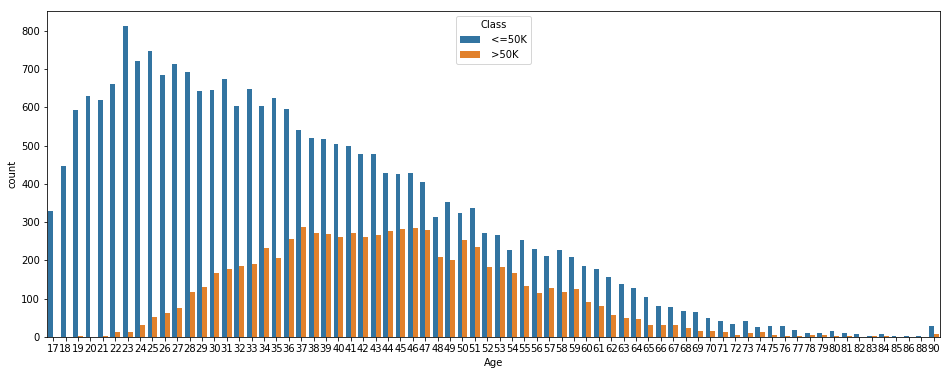

In [7]:
plt.figure(figsize=(16, 6))
plot_Age = sns.countplot(x="Age", data=df, hue="Class")

plot_Age

As one would expect, age seems a good indicator of the income. We see how the frequency of people earning more than 50K increases with age until starts decreasing again. Between ages 45 and 55 the number of people earning more than 50K is almost equal to the people earning less. Then it starts decreasing again.

WORK CLASS

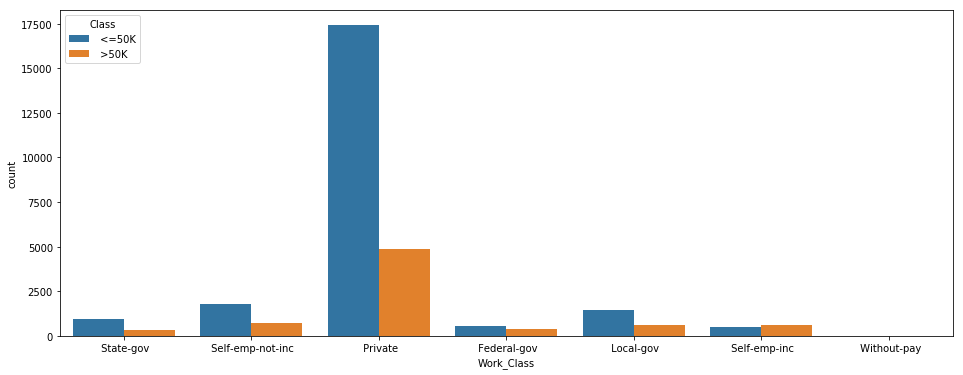

In [8]:
plt.figure(figsize=(16, 6))
plot_Work_Class = sns.countplot(x="Work_Class", data=df, hue="Class")

plot_Work_Class

In this plot we can see two things
- Most people work for private companies and among those, most earn less than 50K
- If a person is self employed is more likely to earn more than 50K

We can group all the observations that work for a public institution in one

In [9]:
# Grouping the categories in one called Government
df["Work_Class"] = df['Work_Class'].replace([" State-gov", " Federal-gov", " Local-gov"], 'Government')

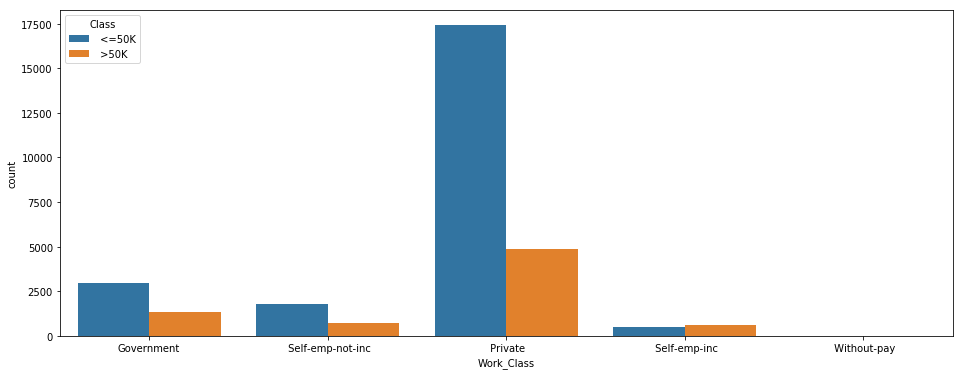

In [10]:
plt.figure(figsize=(16, 6))
plot_Work_Class = sns.countplot(x="Work_Class", data=df, hue="Class")

plot_Work_Class

EDUCATION AND EDUCATION_NUM

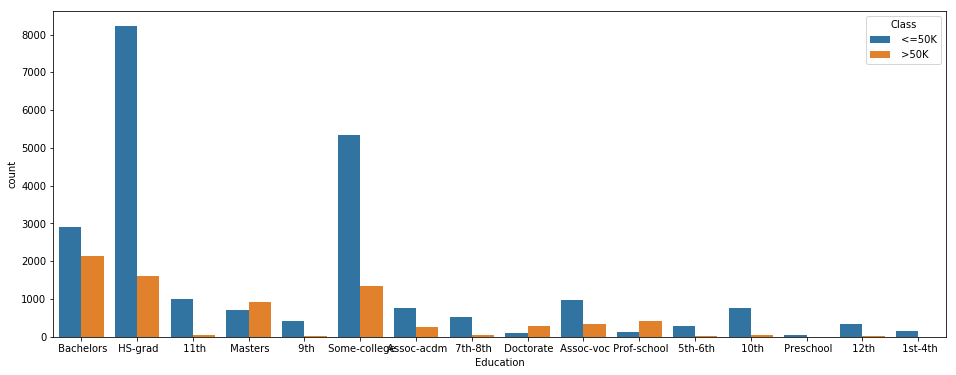

In [11]:
plt.figure(figsize=(16, 6))

plot_Education = sns.countplot(x="Education", data=df, hue="Class")
plot_Education

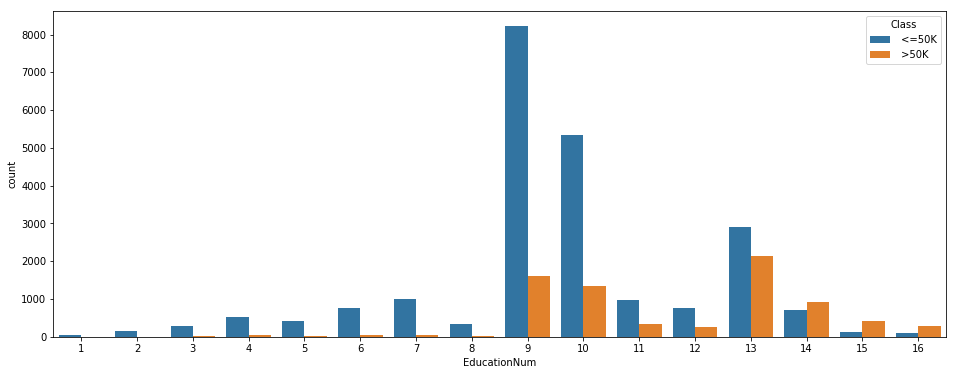

In [12]:
plt.figure(figsize=(16, 6))

plot_EducationNum = sns.countplot(x="EducationNum", data=df, hue="Class")
plot_EducationNum

Education and EducationNum are correlated and we can remove one of them. EducationNum refers to the number of years the person studied and the Education categories the education level. Looking at the chart, EducationNUm seems to be a very good indicator of a person's earnings.

In order to simplify and help reduce dimentionality I will remove Education and keep EducationNum, as it's a numerical feature.

In [13]:
df = df.drop(["Education"],1)

MARITAL STATUS AND RELATIONSHIP

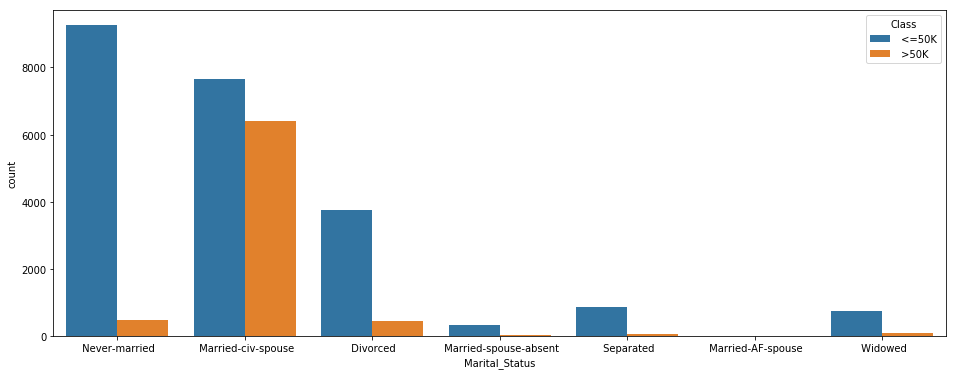

In [14]:
plt.figure(figsize=(16, 6))

plot_Marital_Status = sns.countplot(x="Marital_Status", data=df, hue="Class")
plot_Marital_Status

The logic tells me that we have too many categories and we can group them in less. 

Also, Married-civ-spouse (civil) and Married-AF-spouse (armed forces) can be grouped together. Married spouse absent, means that one of the two members of the married couple doesn´t live in the house at the moment. 

So we can have four different groups: Never married, Separated, Married and Widowed

In [15]:
df["Marital_Status"] = df['Marital_Status'].replace([
    " Divorced", " Married-spouse-absent", " Separated"], 'Separated')
df["Marital_Status"] = df['Marital_Status'].replace([
    " Divorced", " Separated"], 'Separated')
df["Marital_Status"] = df['Marital_Status'].replace([
    " Married-civ-spouse", " Married-AF-spouse"], 'Married')

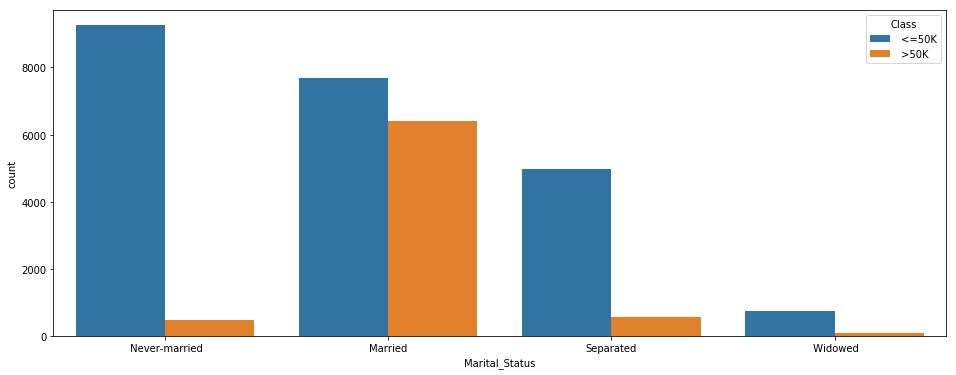

In [16]:
# Let's run the plot again for Marital Status

plt.figure(figsize=(16, 6))

plot_Marital_Status = sns.countplot(x="Marital_Status", data=df, hue="Class")
plot_Marital_Status

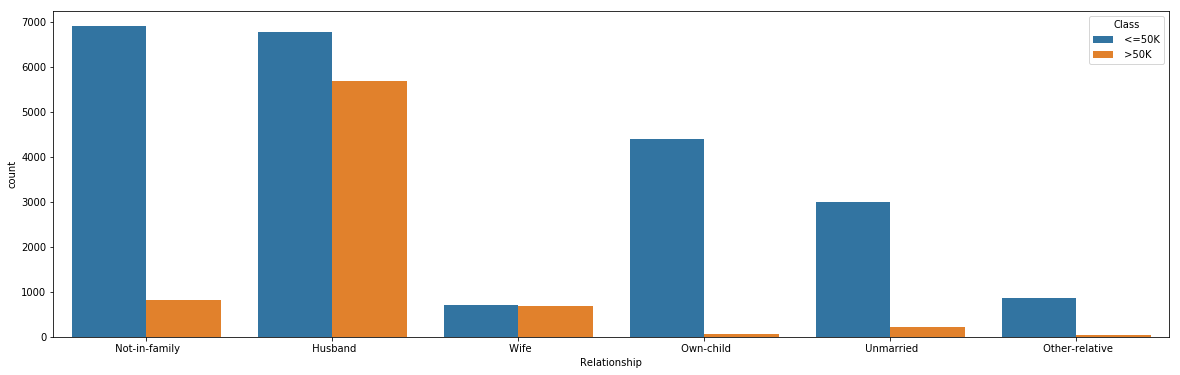

In [17]:
plt.figure(figsize=(20, 6))
plot_Relationship = sns.countplot(x="Relationship", data=df, hue="Class")
plot_Relationship

In [18]:
# Removing feature "Relationship"
df = df.drop(["Relationship"], 1)

First, I will remove the features Relationship as it doesn't give us any new information, it is included in the Marital_Status.

Martital Status is a very interesting feature. I can see that being married increases the likelihood of earning more than 50K, and we can think of this feature as a good feature to classify our observation. However, this might have some correlation with the age. So for example we might think that Never Married people or single people tend to earn less, but this is mostly because the Never Married are younger people and the probability of being married is much lower amongst young people.

Never married would have many young people, whereas Widows will have more density of elderly people. The rest will probably be similar.

Let's create a box plot with Age and Marital Status to see the correlation.

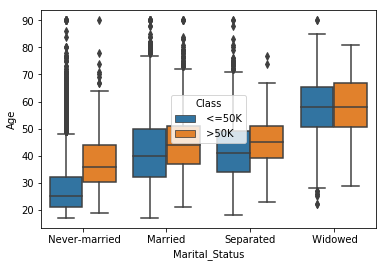

In [19]:
plot_Marital_Status_age = sns.boxplot(x="Marital_Status", y="Age", hue="Class", data=df);
plot_Marital_Status_age

First, it's interesting to see how in all cases elder people tend to earn more. As expected, Never Married category has more young people and most of them are within a range of 22 and 33. Amongst the never married we can see clearly that the age is an important variable to explain earnings.

I added the Class value so we see that age affects the earnings in almost all categories.

OCCUPATION

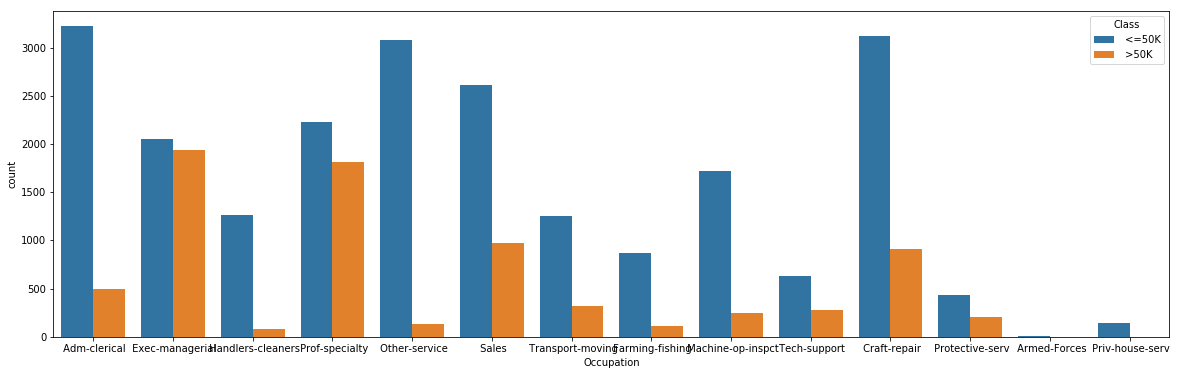

In [20]:
plt.figure(figsize=(20, 6))
plot_Occupation = sns.countplot(x="Occupation", data=df, hue="Class")
plot_Occupation

The Occupation feature is a feature with many different categories. We could potentially group them into sectors, or earnings categoies. However, in this case, I won't group them as I consider them different enough. 

CAPITAL_GAIN and CAPITAL_LOSS

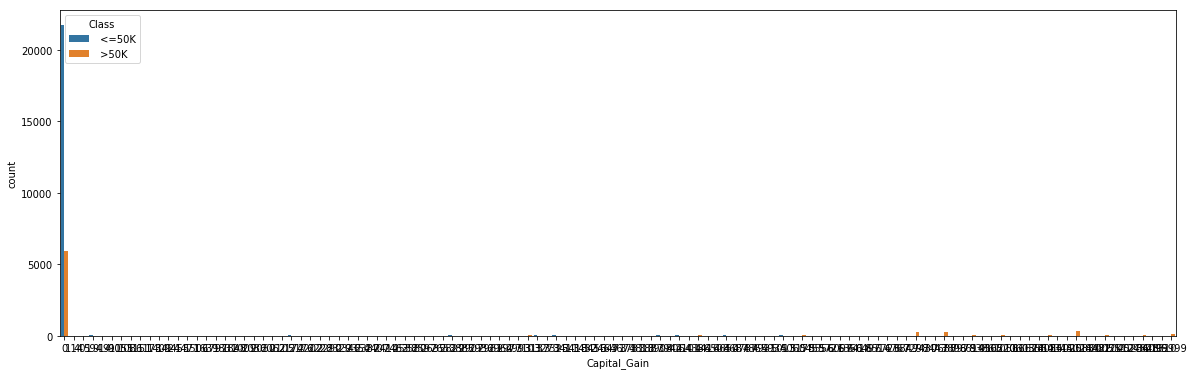

In [21]:
plt.figure(figsize=(20, 6))
plot_Capital_Gain = sns.countplot(x="Capital_Gain", data=df, hue="Class")
plot_Capital_Gain

Capital loss is an interesting features. It tells us the earnings from other sources. Although it might seem very useful the trugh is that more than 90% of the people in the dataset don't have any earnings. Running the following will tell the number of 0s: "print(df.Capital_Gain.value_counts()[0], df.Capital_Loss.value_counts()[0])"
. And obviously the people whose capital gain is more than 50K will always be in the >50K category. This is why this is not a good indicator for a generalist model, it will only create noise in the prediction (although probably increase the accuracy of class >50K). I will drop this category and the category Capital-Loss that follows the same pattern

In [22]:
df = df.drop(["Capital_Gain"],1)
df = df.drop(["Capital_Loss"],1)

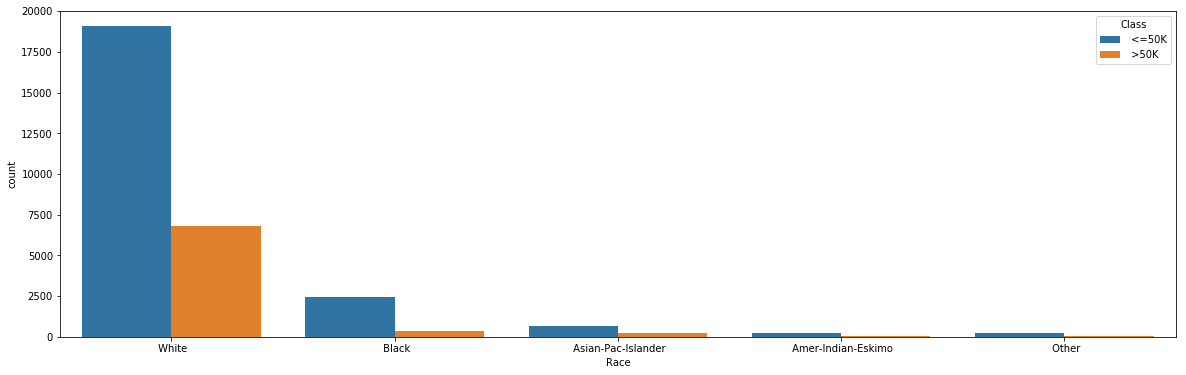

In [23]:
plt.figure(figsize=(20, 6))
plot_Race = sns.countplot(x="Race", data=df, hue="Class")
plot_Race

In [24]:
print(df.Race.value_counts()[" White"], df.Race.value_counts()[" Black"])


25933 2817


SEX

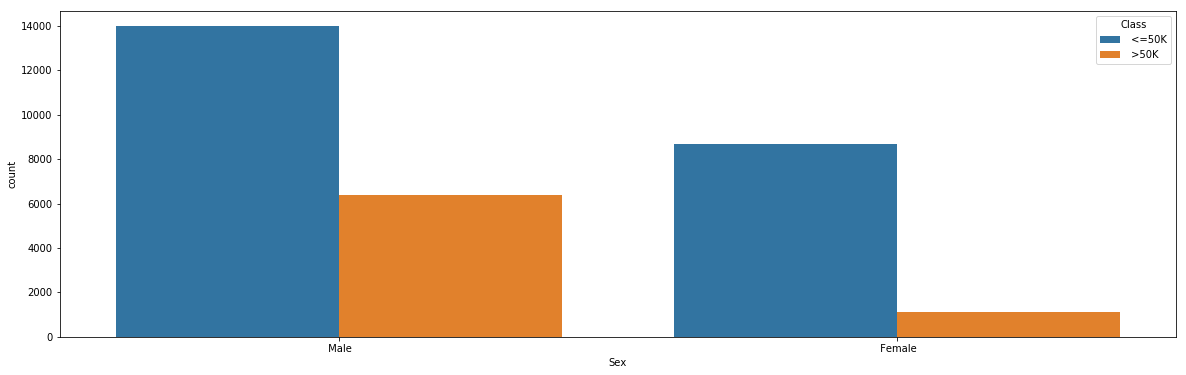

In [25]:
plt.figure(figsize=(20, 6))
plot_Sex = sns.countplot(x="Sex", data=df, hue="Class")
plot_Sex

In [26]:
print("The number of Males in the dataset is: ", 
      df.Sex.value_counts()[" Male"], "\n", "The number of Females in dataset is: ", 
      df.Sex.value_counts()[" Female"])

The number of Males in the dataset is:  20380 
 The number of Females in dataset is:  9782


Sex (or gender) seems to be a good indicator as Male subjects tend to earn more than Female. However, we also see that the sex "Female" is underrepresented with only one third of the observations. In any case, I will leave this feature in.

HOURS PER WEEK

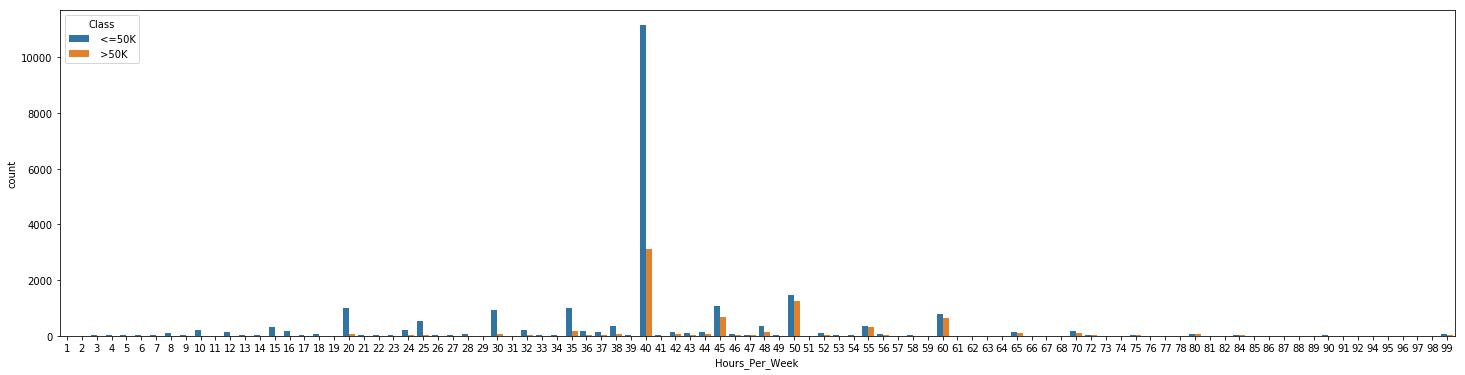

In [27]:
plt.figure(figsize=(25, 6))

plot_Hours_Per_Week = sns.countplot(x="Hours_Per_Week", data=df, hue="Class", orient="v")
plot_Hours_Per_Week

The logic agains tells me that the hours per week should be a good indicator of earnings and the more hours per week a person works the more they should earn. 

The chart is not extremely clear, but we can see that on the left hand side the blue color is more prominent than the orange, whereas on the right hand side of the chart, the orange is closer to blue. Orange being <50K

Let's quickly run a scatterplot with the number of years in education, hours per week and EducationNum

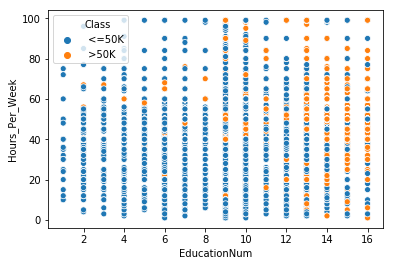

In [28]:
plot_Hours_per_week_education = sns.scatterplot(x="EducationNum", y="Hours_Per_Week", hue="Class", data=df);
plot_Hours_per_week_education

As expected, both Hours Per Week and EducationNum are good indicators. As we see, the number of years in education increases the changes of earning >50K. When education years are higher than 12, we see that you don't necessarily need to work long hours (more than 40) to earn >50K. In the lower numbers of EducationNum however, subjects that earn >50K need to work more than 50 hours per week.

NATIVE COUNTRY

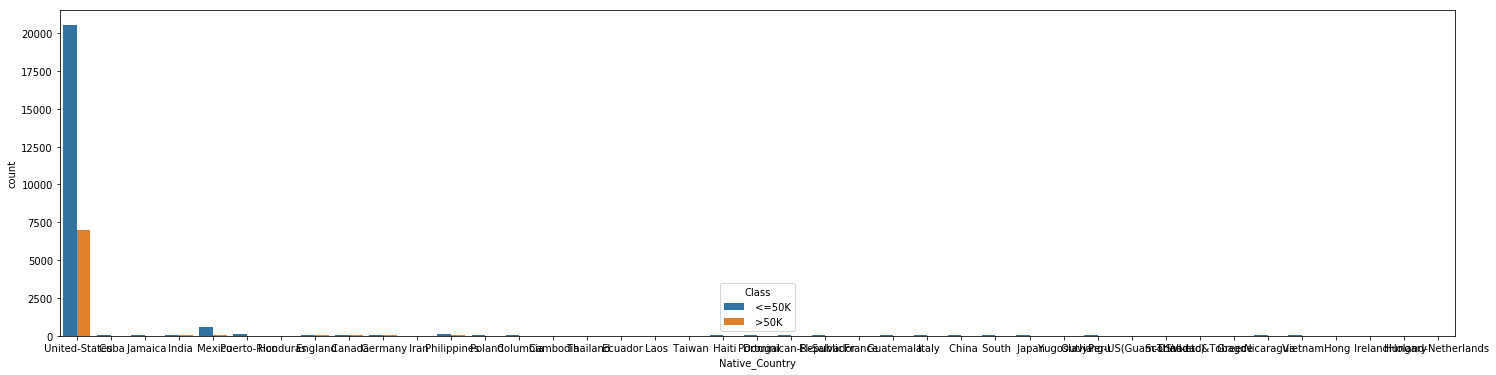

In [29]:
plt.figure(figsize=(25, 6))

plot_Native_Country = sns.countplot(x="Native_Country", data=df, hue="Class", orient="v")
plot_Native_Country

This is the feature with most categories. Of course, this will make our dataset too large and with too many categories for our algorithms to handle and it will probably affect the prediction in a negative way. I will group the different countries in continents (United States, America, Africa, Europe and Asia).

An interesting way to group the countries also would be by their GDP per capita, as I assume that people whose Native Country is richer they would tend to earn more. In Europe for example, it is not the same to come from Norway or from Spain. In Asia it is different to come from Thailand or from Japan. However, for sake of simplicity and geographical reasons I will group them in continents. It is interesting that no African countries are represented here.

In [30]:
# First, let's get a list of unique country values
print (df['Native_Country'].unique())

[' United-States' ' Cuba' ' Jamaica' ' India' ' Mexico' ' Puerto-Rico'
 ' Honduras' ' England' ' Canada' ' Germany' ' Iran' ' Philippines'
 ' Poland' ' Columbia' ' Cambodia' ' Thailand' ' Ecuador' ' Laos'
 ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic' ' El-Salvador'
 ' France' ' Guatemala' ' Italy' ' China' ' South' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']


In [31]:
# Let's group the countries in continents
df["Native_Country"] = df['Native_Country'].replace([
    " Canada", " Cuba", " Jamaica", " Mexico", 
    " Puerto-Rico", " Honduras", " Columbia", " Haiti",
    " Dominican-Republic", " El-Salvador", " Guatemala", 
    " South", " Peru", " Outlying-US(Guam-USVI-etc)", 
    " Trinadad&Tobago", " Nicaragua", " Ecuador"], 'America')

df["Native_Country"] = df['Native_Country'].replace([
    " India", 
    " Iran", " Philippines", " Cambodia", " Thailand", 
    " Laos", " Taiwan", " China", " Japan", " Vietnam", " Hong"], 'Asia')

df["Native_Country"] = df['Native_Country'].replace([
    " England", 
    " Germany", " Poland", " Portugal", " France", 
    " Italy", " Yugoslavia", " Scotland", " Greece", 
    " Ireland", " Holand-Netherlands", " Hungary"], "Europe")

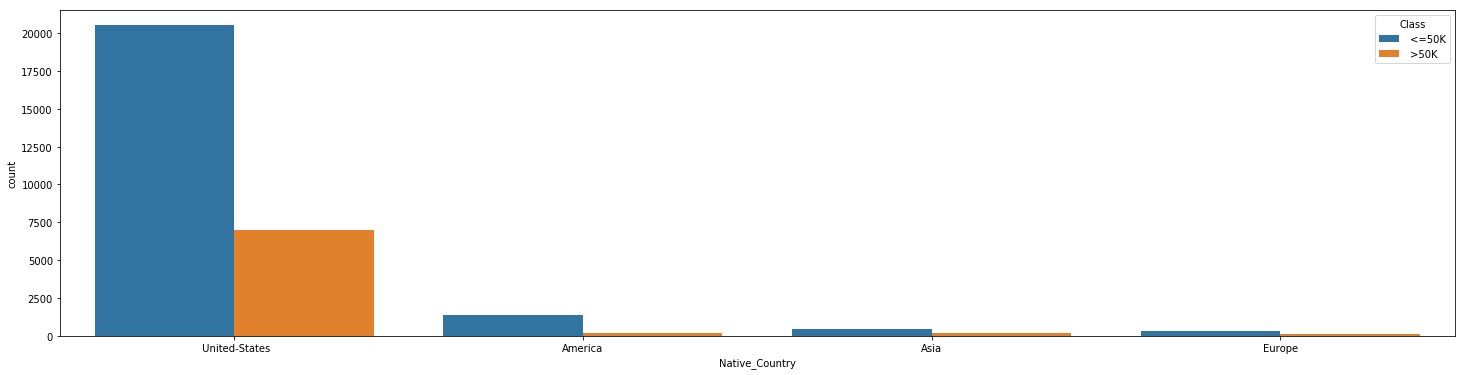

In [32]:
plt.figure(figsize=(25, 6))

plot_Native_Country = sns.countplot(x="Native_Country", data=df, hue="Class", orient="v")
plot_Native_Country

I have finished with the feature analysis. One of the challenges is to work with categorical data as it is more difficult to handle by machines. This is because machines treat each of the categories as a complete different value. So for example, even though us humans can see that in Marital Status "Separated" and "Divorced" can be considered similar, a machine will consider these as different as the relationship between Widowed and Never_Married.

With this analysis I hope I made dataset more consistent and the prediction model more accurate. I removed the features I thought were redundant (e.g. Education) and also the ones that I thought they would lower the general accuracy of the model (Capital Noise and Capital Gain). It also helped me understand some of the relationships between the features.

# Applying classification algorithms with Logistic Regression and Neural Networks

### Logistic Regression

In [33]:
# Let's run the same logistic regression algorithm we ran before and compare the results
df3 = df
df3 = pd.get_dummies(df3, columns=[
    "Work_Class", "Marital_Status", "Occupation", "Race", "Sex", 
    "Native_Country",
])
X_train2, X_test2, y_train2, y_test2 = train_test_split(df3.drop(["Class"], 1), df3["Class"], test_size = 0.2)
log_reg_model2 = LogisticRegression()
log_reg_model2 = log_reg_model2.fit(X_train2, y_train2)
log_pred2 = log_reg_model2.predict(X_test2)
log_conf_matrix2 = confusion_matrix(y_test2, log_pred2)
print(log_conf_matrix2)
print(classification_report(y_test2, log_pred2))
print("Shape of the dataset :",df3.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[4206  342]
 [ 689  796]]
              precision    recall  f1-score   support

       <=50K       0.86      0.92      0.89      4548
        >50K       0.70      0.54      0.61      1485

   micro avg       0.83      0.83      0.83      6033
   macro avg       0.78      0.73      0.75      6033
weighted avg       0.82      0.83      0.82      6033

Shape of the dataset : (30162, 38)


We can see that we get very similar results (slightly better). Probably because we removed unnecesary features (like FnlWgt). But the most important thing is that we end up with only 37 features compared with the 104 we initially had.

In this first approach, I analysed each of the features individually and group different categories based in speific criteria for each of the features. I will use the last df as the final dataset to apply Neural Networks. I do not expect an improvement in accuracy using Neural Networks for this specific problem.

Let's use the Neural Network algorithm included in scikit-learn

### Neural Networks (scikit learn)

In [34]:
# First, let's create a copy of the dataframe and scale the numerical features
# First, let's create a copy of the dataframe and scale the numerical features
df_NN = df
df_NN = pd.get_dummies(df_NN, columns=[
    "Work_Class", "Marital_Status", "Occupation", "Race", "Sex", 
    "Native_Country",
])
df_NN["Age"] = (df_NN["Age"]-df_NN["Age"].min())/(df_NN["Age"].max()-df_NN["Age"].min())
df_NN["EducationNum"] = (
    df_NN["EducationNum"]-df_NN["EducationNum"].min())/(
    df_NN["EducationNum"].max()-df_NN["EducationNum"].min())
df_NN["Hours_Per_Week"] = (
    df_NN["Hours_Per_Week"]-df_NN["Hours_Per_Week"].min())/(
    df_NN["Hours_Per_Week"].max()-df_NN["Hours_Per_Week"].min())

In [35]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(df_NN.drop(["Class"], 1), df_NN["Class"], test_size = 0.2)

In [36]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=100, activation='logistic')
mlp.fit(X_train_NN, y_train_NN)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [37]:
income_pred_NN = mlp.predict(X_test_NN)

In [38]:
conf_matrix = confusion_matrix(y_test_NN, income_pred_NN)
print(conf_matrix)
print(classification_report(y_test_NN, income_pred_NN))

[[4125  439]
 [ 584  885]]
              precision    recall  f1-score   support

       <=50K       0.88      0.90      0.89      4564
        >50K       0.67      0.60      0.63      1469

   micro avg       0.83      0.83      0.83      6033
   macro avg       0.77      0.75      0.76      6033
weighted avg       0.83      0.83      0.83      6033



With the Neural Networks using Scikit Learn package on Python we get similar results compared to the logistic regression. With an accuracy of 77%

### Neural Networks (Keras & TensorFlow)

For Keras, an in order to keep the dataset organised, I created a copy of the original file in a CSV with all the categories cleaned up, get.dummies() applied and with the features scaled

In [39]:
# Below I read the copy of the prepared dataset
# I changed the classes to 0 and 1 and converted the pandas dataframe to arrays
df_tf = df_NN
df_tf["Class"]= df_tf["Class"].replace(" <=50K", 0)
df_tf["Class"]= df_tf["Class"].replace(" >50K", 1) 
Y_tf = df_tf["Class"]
Y_tf = Y_tf.values # Converting to nupy array
X_tf = df_tf.drop(["Class"], 1)
X_tf = X_tf.values # Converting to numpy array

In [40]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, Y_tf, test_size = 0.3)

Let's create a model similar to the one I ran in MLPClassifier. One input layer, one hidden layer
In order to be able to load the session data into TensorBoard, I opened the below instance in the terminal
tensorboard --logdir=/Users/jon/Documents/LSBU/1\ Machine\ Learning/Machine\ Learning\ project/Project/logs --port=8080 
Difference between epoch and batch:
- Batch refers to the number of observations used each time for forward and back propagation
- Epoch refers to the number of times all of the observations were used

In [41]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(30, input_dim=37, activation="relu"), # 37 input features
  tf.keras.layers.Dropout(0),
  tf.keras.layers.Dense(20, activation="sigmoid") # sigmoid activation for a binary classification (0 or 1)
]) 
adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy', # Sparse as the classification is numerical
              metrics=['accuracy'])
tensorboard = TensorBoard(log_dir="logs/".format(time))
y_pred_tf = model.predict_classes(x=X_test_tf, batch_size=1000)
history = model.fit(X_train_tf, y_train_tf, epochs=10, callbacks=[tensorboard])
print(model.evaluate(X_test_tf, y_test_tf))

Epoch 1/10
21113/21113 [==============================] - 2s 90us/step - loss: 0.7246 - acc: 0.7377
Epoch 2/10
21113/21113 [==============================] - 2s 76us/step - loss: 0.4062 - acc: 0.7520
Epoch 3/10
21113/21113 [==============================] - 2s 75us/step - loss: 0.3914 - acc: 0.7980
Epoch 4/10
21113/21113 [==============================] - 2s 80us/step - loss: 0.3775 - acc: 0.8208
Epoch 5/10
21113/21113 [==============================] - 2s 77us/step - loss: 0.3701 - acc: 0.8241: 1s - loss: 0.3782 - acc - ETA: 0s - loss: 0.374
Epoch 6/10
21113/21113 [==============================] - 2s 77us/step - loss: 0.3660 - acc: 0.8263
Epoch 7/10
21113/21113 [==============================] - 2s 80us/step - loss: 0.3628 - acc: 0.8254
Epoch 8/10
21113/21113 [==============================] - 2s 75us/step - loss: 0.3616 - acc: 0.8285: 1s -
Epoch 9/10
21113/21113 [==============================] - 2s 77us/step - loss: 0.3605 - acc: 0.8274: 0s - loss: 0.3586 - acc: 
Epoch 10/10
9049/9

In [42]:
y_pred_tf = model.predict_classes(x=X_test_tf, batch_size=32)
print(y_pred_tf)
print(classification_report(y_test_tf, y_pred_tf))

[0 0 0 ... 1 0 0]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      6787
           1       0.67      0.61      0.64      2262

   micro avg       0.83      0.83      0.83      9049
   macro avg       0.77      0.76      0.76      9049
weighted avg       0.82      0.83      0.83      9049



dict_keys(['loss', 'acc'])


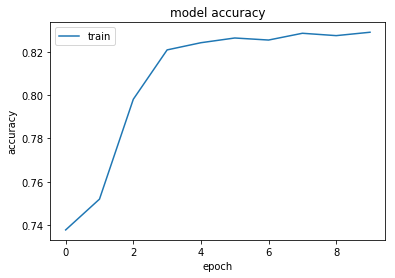

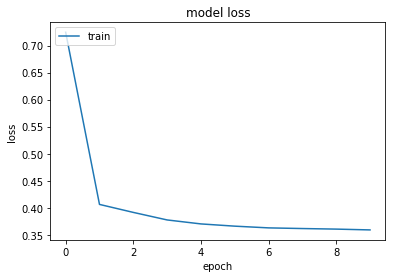

In [43]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Using TensorBoard to visualize the learning process

The below shows the improvement of the accuracy through the different epochs
This is the total accuracy for both classes
10 epoch seems to be the most efficient. More than 10 will barely increase the accuracy
I tried using lower learning rate, batch number increasing the epochs and the accuracy barely increases from 77%
The accuracy shown in the chart below is the combined of both classes. The class <=50K has always better accuracy

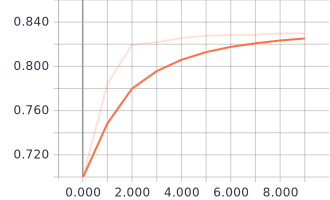

In [44]:
SVG(filename='epoch_acc.svg')

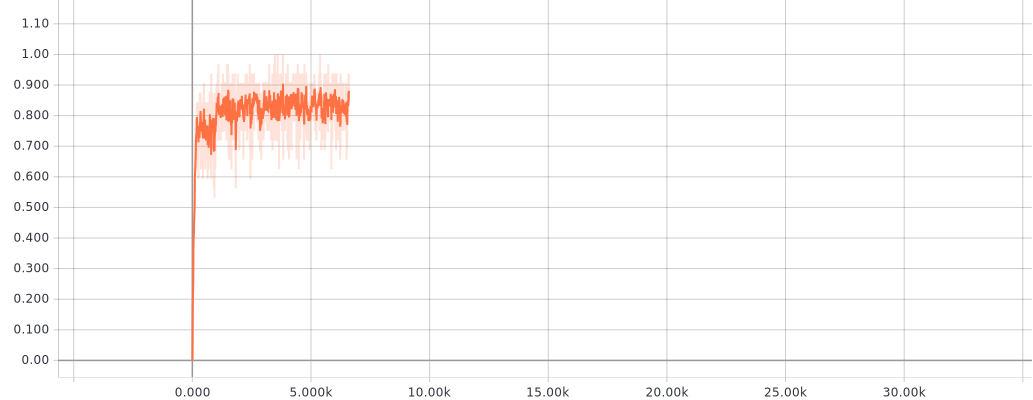

In [45]:
# The below shows the accuracy per batch (each batch was 1000)
SVG(filename='batch_acc.svg')

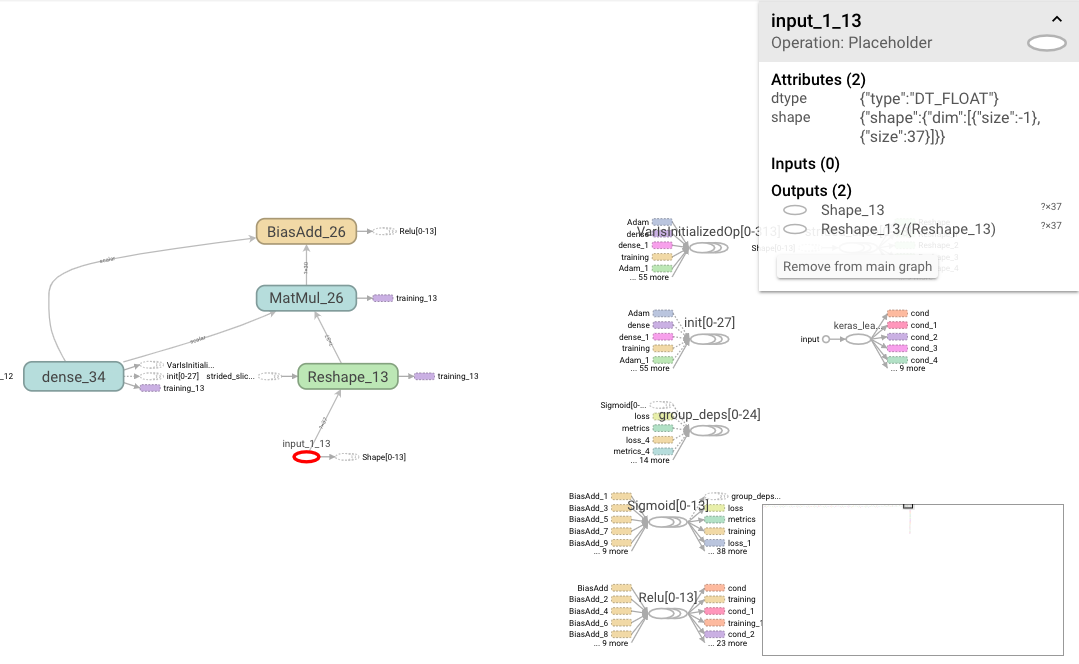

In [46]:
# The below shows a brief look at the flowchart of the model we ran, with the interactions between elements
# It is a massive graph so I just took a screenshot of a portion
Image(filename='TensorBoard_Graph.png')

### Neural Networks: Pytorch

This implementation ist's a low level impllementation compared to Keras implementation or scikitlearn and it's more similar to working on plain python. I had to one hot encode the classes and used two output nodes, one for each of the classes.

In [47]:
encoder_train = LabelEncoder() # first one hot encode the classes so they become 1,0 or 0,1. For test and training
encoder_train = encoder_train.fit(y_train_tf)
y_train_tf2 = encoder_train.transform(y_train_tf)
y_train_tf2 = np_utils.to_categorical(y_train_tf2)

encoder = LabelEncoder()
encoder = encoder.fit(y_test_tf)
y_test_tf2 = encoder.transform(y_test_tf)
y_test_tf2 = np_utils.to_categorical(y_test_tf2)

# converting train and test observations to torch tensor object
X_train_tensor = Variable(torch.FloatTensor(X_train_tf), requires_grad = False)
y_train_tensor = Variable(torch.FloatTensor(y_train_tf2), requires_grad = False)
X_test_tensor = Variable(torch.FloatTensor(X_test_tf), requires_grad = False)
y_test_tensor = Variable(torch.FloatTensor(y_test_tf2), requires_grad = False)

In [48]:
# Model set up
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.h_layer = nn.Linear(37, 30) # 37 input features and 1 hidden layer with 30 nodes
        self.act_h = nn.ReLU() #
        self.i_layer = nn.Linear(30, 2) # 1 output layer with 2 output nodes because classes are one-hot encoded
        self.s_layer = nn.Sigmoid()
    def forward(self,x):  # passing the observations through the layers and activation functions
        y = self.h_layer(x)
        a = self.act_h(y)
        q = self.i_layer(a)
        p = self.s_layer(q)
        return p
model_pytorch = LinearClassifier() 
loss_fn = nn.BCELoss() # calculates the loss
optim = torch.optim.Adam(model_pytorch.parameters(), lr = 0.04) # using the Adam optimizer for weights update

In [49]:
# training the algorithm for 100 iterations and recording the loss
all_losses = []
for num in range(100): 
    pred = model_pytorch(X_train_tensor) # this predicts the class of training data
    loss = loss_fn(pred, y_train_tensor) # calculates loss based on real values
    all_losses.append(loss.data)
    optim.zero_grad()
    loss.backward() # updates the weights based on loss
    optim.step() # update optimiser for next iteration

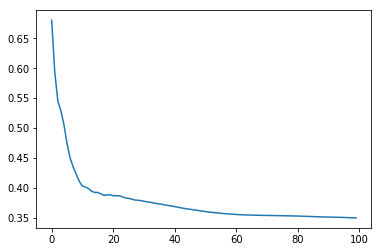

tensor([0.9894, 0.0114], grad_fn=<SelectBackward>)
tensor([1., 0.])
0.3500494956970215


In [50]:
# plotting the loss of every iteration
%matplotlib inline
all_losses = np.array(all_losses, dtype = np.float)
plt.plot(all_losses)
plt.show()
print(pred[3])
print(y_train_tensor[3])
print(all_losses[-1])

In [51]:
from sklearn.metrics import accuracy_score
predicted_values_pytorch_tensor = []
for num in range(len(X_test_tensor)):
    predicted_values_pytorch_tensor.append(model_pytorch(X_test_tensor[num]))

predicted_values_pytorch = []
for item in predicted_values_pytorch_tensor:
    predicted_values_pytorch.append(np.argmax(item.data.numpy()))

test_values_pytorch = []
for item in y_test_tensor:
    test_values_pytorch.append(np.argmax(item))

correct_pytorch = 0
for prediction_pytorch, test_pytorch in zip(predicted_values_pytorch, test_values_pytorch):
    if prediction_pytorch == test_pytorch:
        correct_pytorch = correct_pytorch+1
        
accuracy_pytorch = correct_pytorch/len(predicted_values_pytorch)

print("The accuracy of the model using pytorch is: "+str(accuracy_pytorch*100)+"%")

The accuracy of the model using pytorch is: 83.02574870151398%


In [52]:
Pytorchconf = confusion_matrix(test_values_pytorch, predicted_values_pytorch)
print(Pytorchconf)
print(classification_report(test_values_pytorch, predicted_values_pytorch))

[[6217  570]
 [ 966 1296]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      6787
           1       0.69      0.57      0.63      2262

   micro avg       0.83      0.83      0.83      9049
   macro avg       0.78      0.74      0.76      9049
weighted avg       0.82      0.83      0.82      9049



# Comparison with other Classification Algorithms

### KNN

In [53]:
KNNmodel = KNeighborsClassifier(n_neighbors=11) # best priority with K between 5-20
KNNmodel = KNNmodel.fit(X_train2, y_train2)
KNNpredictions = KNNmodel.predict(X_test2)
KNNconf = confusion_matrix(y_test2, KNNpredictions)
print(KNNconf)
print(classification_report(y_test2, KNNpredictions))

[[4074  474]
 [ 660  825]]
              precision    recall  f1-score   support

       <=50K       0.86      0.90      0.88      4548
        >50K       0.64      0.56      0.59      1485

   micro avg       0.81      0.81      0.81      6033
   macro avg       0.75      0.73      0.74      6033
weighted avg       0.81      0.81      0.81      6033



### Bayes theorem

In [54]:
bayesmodel = GaussianNB()
bayesmodel = bayesmodel.fit(X_train2, y_train2)
bayespred = bayesmodel.predict(X_test2)
Bayesconf = confusion_matrix(y_test2, bayespred)
print(Bayesconf)
print(classification_report(y_test2, bayespred))

[[2218 2330]
 [ 126 1359]]
              precision    recall  f1-score   support

       <=50K       0.95      0.49      0.64      4548
        >50K       0.37      0.92      0.53      1485

   micro avg       0.59      0.59      0.59      6033
   macro avg       0.66      0.70      0.58      6033
weighted avg       0.80      0.59      0.61      6033



### Decision Tree

In [55]:
treemodel = tree.DecisionTreeClassifier()
treemodel = treemodel.fit(X_train2, y_train2)
treepred = treemodel.predict(X_test2)
treeconf = confusion_matrix(y_test2, treepred)
print(treeconf)
print(classification_report(y_test2, treepred))

[[3966  582]
 [ 686  799]]
              precision    recall  f1-score   support

       <=50K       0.85      0.87      0.86      4548
        >50K       0.58      0.54      0.56      1485

   micro avg       0.79      0.79      0.79      6033
   macro avg       0.72      0.71      0.71      6033
weighted avg       0.79      0.79      0.79      6033



### Support Vector Machines

In [56]:
svmmodel = svm.SVC(gamma='scale')
svmmodel = svmmodel.fit(X_train2, y_train2)
svmpred = svmmodel.predict(X_test2)
svmconf = confusion_matrix(y_test2, svmpred)
print(svmconf)
print(classification_report(y_test2, svmpred))

[[4307  241]
 [ 797  688]]
              precision    recall  f1-score   support

       <=50K       0.84      0.95      0.89      4548
        >50K       0.74      0.46      0.57      1485

   micro avg       0.83      0.83      0.83      6033
   macro avg       0.79      0.71      0.73      6033
weighted avg       0.82      0.83      0.81      6033



# PCA

37 features after applying the one hot encoding seem a lot of features and we might get similar results reducing the dimensionality of the data, so let's quickly run a PCA to see if we can keep a consisten accuracy reducing the dimensionality. I will use Logistic Regression to test the accuracy.

In [57]:
df_4 = df3 #creating copy of the dataframe
df_4_Y = df_4["Class"]
df_4_X = df_4.drop(["Class"], 1)

In [58]:
pca_allcomponents = PCA(n_components=37)
principalComponents = pca_allcomponents.fit_transform(df_4_X)
principalDf = pd.DataFrame(data = principalComponents)
features_PCA = pca_allcomponents.explained_variance_ratio_

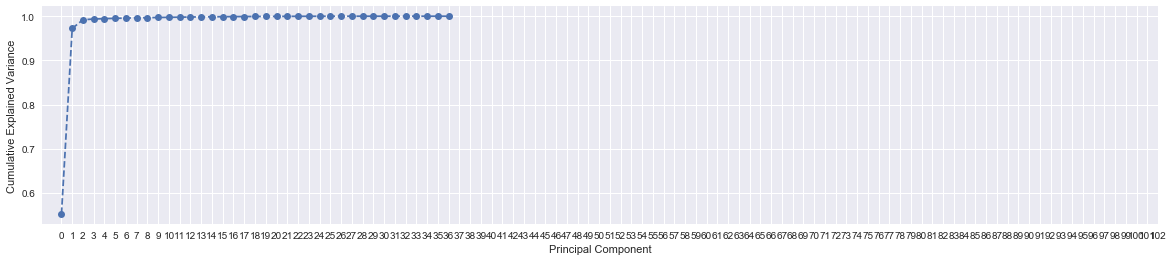

In [59]:
# plotting the accumulated explained variance of the principal components sorted by importance

plt.style.use('seaborn')

def plot_pca():
    plt.figure(figsize = (20, 4))
    plt.plot(np.cumsum(pca_allcomponents.explained_variance_ratio_), '--o')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.xticks(np.arange(0, 103, 1.0))
    plt.show()

plot_pca()

The chart shows that the first principal component explains almost all the variance. But I will use 5 for this example to see if it works well. This reduces the dimensionality of the data from 37 dimensions to only 5 and from the chart I presume I will get good results

In [60]:
# applying PCA to our data with 5 principal components
pca = PCA(n_components=5)
df_4_X_PCA = pca.fit_transform(df_4_X)
df_4_X_PCA = pd.DataFrame(data = df_4_X_PCA)

In [61]:
# creating new test and train data from our 5 dimensional subspace
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(df_4_X_PCA, df_4_Y, test_size = 0.3)

### Logistic Regression with PCA transformed data with 5 principal components

In [62]:
log_reg_model_PCA = LogisticRegression()
log_reg_model_PCA = log_reg_model_PCA.fit(X_train_PCA, y_train_PCA)
log_pred_PCA = log_reg_model_PCA.predict(X_test_PCA)
log_conf_matrix_PCA = confusion_matrix(y_test_PCA, log_pred_PCA)
print(log_conf_matrix)
print(classification_report(y_test_PCA, log_pred_PCA))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[6547  252]
 [1655  595]]
              precision    recall  f1-score   support

       <=50K       0.84      0.93      0.88      6771
        >50K       0.68      0.46      0.55      2278

   micro avg       0.81      0.81      0.81      9049
   macro avg       0.76      0.69      0.71      9049
weighted avg       0.80      0.81      0.80      9049



Reducing dimensionality from 37 to 5 using PCA, the accuracy drops only by 2-3 points. If we are happy with these results we will get consistent results reducing the training time of the algorithms.

# Conclusion

The accuracy of the machine learning algorithms used in this document are:


Logistic regression before data pre-processing : 77%

-------------------------

Logistic regression after data pre-processing : 82%

Neural Networks using Scikit Learn: 82%

Neural Networks using TensorFlow (Keras): 83%

Neural Network using PyTorch: 83%

-------------------------

KNN with K=11: 80%

Bayes (Gaussian): 80%

Decision Tree: 70%

Support Vector Machines: 81%

-------------------------

PCA and Logistic Regression: 80%

-------------------------
*Please note that these are not dynamic values, so they may slightly change based on the train/test split




After running a Logistic Regression to the data before applying any pre-processing I got an accuracy of 77%, which I felt it was a good result considering the problem I was trying to solve. 

After dropping unimportant features that only added noise, normalizing data and preparing the classes I was able to improve the accuracy by 5 points reaching 82% using Logistic Regression.

I used three different libraries or frameworks for Neural Networks and compared them with the results of Logistic Regression: NN module of Scikit Learn, TensorFlow and Pytorch trying to achieve a NN structure as similar as possible in each of them. The results were very similar, reaching 83% with TensorFlow and PyTorch, 1 point better than the results with Logistic Regression. It was very interesting to explore the ability to visualize the operations with TensorBoard. Keras made using TensorFlow very easy as it's a high level tool included with TF. PyTorch was a challenge to understand as it's a lower level library.

At the end I used four classification algorithms to see how well they performed compared to the NN: KNN, Bayes, Decision Trees and Support Vector Machines. They didn't perform as well as the NN or a Logistic Regression but they were all around 80% accuracy. It is interesting to see that Bayes algorithm performs very well with the most popular class but it performs poorly when predicting the least popular class.

The dataset was a bit unbalanced, as there were more observations of class <=50K than >50K. The algorithms tend to perform better with the class with more observations. Some of the features are also a bit unbalanced, like gender. It could be a good idea for further research to drop some random observations for class <=50K so the two classes are balanced and see the results.

Training was a bit slow on my computer generally using all algorithms due to the dimensionality of the data and the number of features. As shown at the end of the notebook, using PCA I could drastically reduce dimensionality by keeping the accuracy above 80% using logistic regression. Training using the PCA transformed data with only 5 dimensions was much faster.


In regards to the accuracy, it would be difficult to find a generalized model to predict if a person will earn more or less of 50K. Due to the nature of the problem it is impossible to know how much a person earns because this depends on factors that can't be meassured. Based on the features gathered in this dataset, maybe with some extra data pre-processing and balancing the features and the classes the results can be improved, but probabily very slightly.